In [2]:
import pyranges as pr
import pandas as pd
import gzip
import time
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

In [193]:
class Annotation:
    
    def __init__(self, gtf_file_name):  
        
        self.gtf_df = self.parse_gtf(gtf_file_name)
        dfs = self.create_reduced_dfs(self.gtf_df)
        self.genes = dfs[0]
        self.transcripts = dfs[1]
        self.exons = dfs[2]
        
    def parse_gtf(self, gtf_file_name):
        """
        Opens a zipped gtf file and parses it for gene information
        :param gtf_file_name: A .gz zipped file
        :return:
        """
        
        # Open the zipped gtf file
        f = gzip.open(gtf_file_name, 'r')
        file_content = f.read()
        file_content = file_content.decode('utf-8')
        f_out = open(gtf_file_name[:-3], 'w+')  # Create the .gtf file that is extracted form the zipped .gz file
        f_out.write(file_content)
        f.close()
        f_out.close()
        # Turn the .gtf file into a pandas dataframe
        gene_info_pr = pr.read_gtf(gtf_file_name[:-3])
        gene_info = gene_info_pr.df
        return gene_info
    
    def create_reduced_dfs(self, gtf_df):
        """
        Creates dataframes that only include entries from the gtf_df that are genes, transcripts, or exons. The columns are reduced
        :return: a tuple of dataframes (genes, transcripts, exons)
        """
        
        genes = gtf_df[gtf_df["Feature"] == "gene"].loc[:,['gene_id', 'gene_name', 'gene_biotype', 'Chromosome', 'Strand', 
                                                            'Source', 'Start', 'End', 'gene_version']]
        transcripts = gtf_df[gtf_df["Feature"] == "transcript"].loc[:,['transcript_id', 'gene_id',  'transcript_name', 'transcript_biotype',
                                                                  'Start', 'End', 'transcript_version']]
        exons = gtf_df[gtf_df["Feature"] == "exon"].loc[:,['exon_id', 'gene_id', 'transcript_id', 'exon_number', 'Start', 'End',
                                                            'exon_version']]
        
        return genes, transcripts, exons
    
        
    def create_database_table_files(self, gname, tname, ename):
        """
        Creates tab delimited text files that can be used to construct mysql tables
        :param gtf_df: A gtf info dataframe with all the columns still in it
        """
        
        self.genes.to_csv(gname, sep="\t", index=None)
        self.transcripts.to_csv(tname, sep="\t", index=None)
        self.exons.to_csv(ename, sep="\t", index=None)
        
        
    def find_num_chromosomes(self):
        """
        Counts the number of chromosomes in an assembly and the number of contigs, and prints the output
        """
        
        chrom_contig = self.genes["Chromosome"].value_counts().index
        contig = 0
        chrom = 0
        for string in chrom_contig:
            if "Contig" in string or "Ultra" in string or "RZJT" in string:
                contig += 1
            else:
                chrom += 1
    
        print(contig, chrom)
        
    def find_genes_with_name(self):
        """
        Returns a dataframe that only includes genes with a non 'NaN' value for their gene name
        :return: a dataframe of genes
        """
        
        return self.genes[~self.genes["gene_name"].isna()]
    
    
    def find_non_redundant_genes(self):
        """
        Returns a dataframe of genes with no repeats in the gene names
        :return: a dataframe of genes
        """
        
        return set(self.genes["gene_name"])
    
    def find_shared_gene_ids(self, genes):
        """
        Returns a set of genes with gene ids that are present in both the versions being compared
        :param genes: the dataframe of genes that is being compared
        :return: a set of gene ids
        """
        
        sg1 = set(self.genes["gene_id"])
        sg2 = set(genes["gene_id"])
        shared_ids = sg1.intersection(sg2)
        
        return shared_ids

        
    def find_unique_gene_ids(self, genes):
        """
        Returns a dataframe of genes with gene ids that are only present in the version that is being compared
        :param genes: the dataframe of genes that is being compared
        :return: a datfarame of genes
        """
        
        sg1 = set(self.genes["gene_id"])
        sg2 = set(genes["gene_id"])

        unique_gene_ids = sg1 - sg2
        unique_gene_ids_df = self.genes[self.genes["gene_id"].isin(unique_gene_ids)]

        return unique_gene_ids_df
    
    def find_unique_gene_names(self, genes):
        """
        Returns a dataframe of genes with gene names that are only present in the version that is being compared
        :param genes: the dataframe of genes that is being compared
        :return: a datfarame of genes
        """
        
        sg1 = set(self.genes["gene_name"])
        sg2 = set(genes["gene_name"])

        unique_gene_ids = sg1 - sg2
        unique_gene_ids_df = self.genes[self.genes["gene_name"].isin(unique_gene_ids)]

        return unique_gene_ids_df
    
        
    def get_gtf(self):
        """
        Returns the gtf dataframe
        :return: gtf dataframe
        """
        
        return self.gtf_df
    
    def get_genes(self):
        """
        Returns the genes dataframe
        :return: genes dataframe
        """
        
        return self.genes
    
    def get_transcripts(self):
        """
        Returns the genes dataframe
        :return: genes dataframe
        """
        
        return self.transcripts
    
    def get_exons(self):
        """
        Returns the genes dataframe
        :return: genes dataframe
        """
        
        return self.exons
    

In [200]:
old = Annotation("Ornithorhynchus_anatinus.OANA5.97.gtf.gz")
new = Annotation("Ornithorhynchus_anatinus.mOrnAna1.p.v1.108.gtf.gz")

### Creating files for the database

In [201]:
old.create_database_table_files("Old_Gene.txt", "Old_Transcript.txt", "Old_Exon.txt")
new.create_database_table_files("New_Gene.txt", "New_Transcript.txt", "New_Exon.txt")

### Finding information for first table on webpage

In [202]:
# Find total number of genes in each assembly
print(len(old.genes), len(new.genes))

29776 26272


In [203]:
# Find total number of transcripts in each assembly
print(len(old.transcripts), len(new.transcripts))

32009 42892


In [204]:
# Find number of contigs and chromosomes for each assembly

old.find_num_chromosomes()
new.find_num_chromosomes()

15122 20
62 27


In [205]:
# Find number of genes with names

old_with_names = old.find_genes_with_name()
new_with_names = new.find_genes_with_name()

print(len(old_with_names), len(new_with_names))

10027 12251


In [206]:
# Find number of non redundant gene names

old_name_set = old.find_non_redundant_genes()
new_name_set = new.find_non_redundant_genes()

print(len(old_name_set), len(new_name_set))

7192 11791


In [207]:
# Find gene ids that are in 108 and not in 97, and vice versa

old_unique_ids = old.find_unique_gene_ids(new.genes)
new_unique_ids = new.find_unique_gene_ids(old.genes)

print(len(old_unique_ids), len(new_unique_ids))

18879 15375


In [208]:
# Find gene names that are in 108 and not in 97, and vice versa

old_unique_names = old.find_unique_gene_names(new.genes)
new_unique_names = new.find_unique_gene_names(old.genes)

print(len(old_unique_names), len(new_unique_names))

3959 6194


### Finding information for the second table in the webpage

In [209]:
# Finding genes in 108 with 10 transcripts

new.genes["gene_id"].mode()[:3]

0    ENSOANG00000000111
1    ENSOANG00000000112
2    ENSOANG00000000113
Name: gene_id, dtype: object

In [210]:
# Finding genes in 108 with 4 transcripts

old.genes["gene_id"].mode()[:3]

0    ENSOANG00000000110
1    ENSOANG00000000111
2    ENSOANG00000000112
Name: gene_id, dtype: object

In [211]:
# Finding unique 108 genes

new_unique_ids[:3]

,gene_id,gene_name,gene_biotype,Chromosome,Strand,Source,Start,End,gene_version
0,ENSOANG00000039864,NaN,protein_coding,1,+,ensembl,26897110,26969536,1
119,ENSOANG00000037521,NaN,snoRNA,1,+,ensembl,177628748,177628886,1
122,ENSOANG00000041896,NaN,snoRNA,1,+,ensembl,59133,59270,1


In [214]:
# Finding genes ids with no name in release 97 but were assigned a name in release 108

shared_ids = old.find_shared_gene_ids(new.genes)
old_shared_df = old.genes[old.genes["gene_id"].isin(shared_ids)]
new_shared_df = new.genes[new.genes["gene_id"].isin(shared_ids)]

nan_in_97 = old_shared_df[old_shared_df["gene_name"].isna()]["gene_id"]
nan_in_97_108 = new_shared_df[new_shared_df["gene_id"].isin(nan_in_97)]
name_in_108 = nan_in_97_108[~nan_in_97_108["gene_name"].isna()]

print(len(name_in_108))
name_in_108[:3]

2574


,gene_id,gene_name,gene_biotype,Chromosome,Strand,Source,Start,End,gene_version
834,ENSOANG00000020697,RSRC1,protein_coding,1,+,ensembl,153133266,153515204,3
1053,ENSOANG00000003406,PPP2R3A,protein_coding,1,+,ensembl,167969318,168095719,4
1146,ENSOANG00000013086,ZSWIM6,protein_coding,1,+,ensembl,545181,608622,2


In [215]:
# Finding unique 97 genes that don't have a gene name

old_unique_ids_no_name = old_unique_ids[old_unique_ids["gene_name"].isna()]

print(len(old_unique_ids_no_name))
old_unique_ids_no_name[:3]

14785


,gene_id,gene_name,gene_biotype,Chromosome,Strand,Source,Start,End,gene_version
149,ENSOANG00000030838,NaN,protein_coding,1,+,ensembl,2294145,2302661,1
232,ENSOANG00000035851,NaN,lincRNA,1,+,ensembl,3181459,3188904,1
241,ENSOANG00000033321,NaN,lincRNA,1,+,ensembl,3236383,3241790,1


In [225]:
# Finding unique 97 genes that have a gene name

old_unique_ids_with_name = old_unique_ids[~old_unique_ids["gene_name"].isna()]

print(len(old_unique_ids_with_name))
old_unique_ids_with_name[:3]

4094


,gene_id,gene_name,gene_biotype,Chromosome,Strand,Source,Start,End,gene_version
15,ENSOANG00000011202,MOCS2,protein_coding,1,+,ensembl,377292,387113,3
31,ENSOANG00000027707,RF01293,snoRNA,1,+,ensembl,998703,998876,1
284,ENSOANG00000011074,MBLAC2,protein_coding,1,+,ensembl,5264418,5275935,2


In [223]:
# Show that the presence of a gene name makes it possible to find an analog in the 108 release by searching for the gene name,
# but not always...

new.genes[new.genes["gene_name"] == "ENSOANG00000011074"]

,gene_id,gene_name,gene_biotype,Chromosome,Strand,Source,Start,End,gene_version


In [222]:
# Find genes with gene ids that only occur in release 97, but have a name that occurs in a gene with a different gene id in release 108

also_in_108 = new.genes[new.genes["gene_name"].isin(old_unique_ids_with_name["gene_name"])]
print(len(also_in_108))
also_in_108[:3]

1114


,gene_id,gene_name,gene_biotype,Chromosome,Strand,Source,Start,End,gene_version
351,ENSOANG00000047492,PTX3,protein_coding,1,+,ensembl,152430741,152436345,1
966,ENSOANG00000049528,MLF1,protein_coding,1,+,ensembl,153548019,153602694,1
1564,ENSOANG00000040965,VSNL1,protein_coding,1,+,ensembl,92964472,93157247,1


### Making the graphs for the webpage

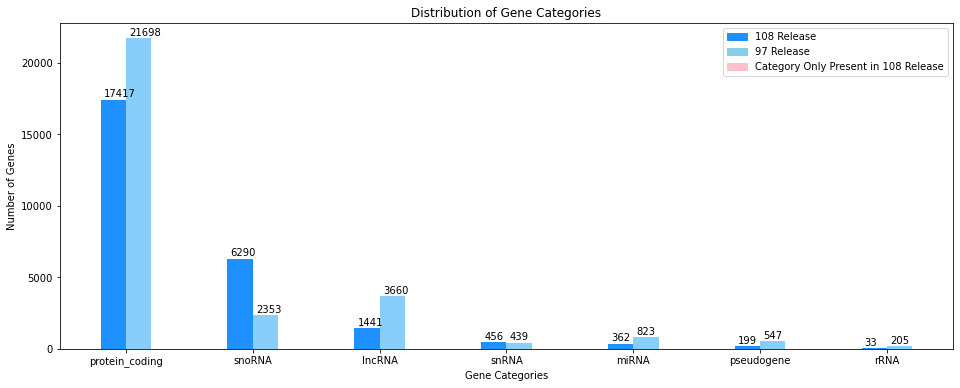

In [217]:
# Plot the gene categories against the number of times they occur in genes, for both assemblies - Part 1

ng = new.genes

categories1 = ng["gene_biotype"].value_counts().index.tolist()[:7]
new_category_counts1 = ng["gene_biotype"].value_counts()[:7]
old_category_counts1 = [21698, 2353, 3660, 439, 823, 547, 205]

# Make a numpy array for the positional information of each "bar pair"
x_axis = np.arange(len(categories1))

fig = plt.figure(figsize=(16, 6))
plt.title("Distribution of Gene Categories")
plt.xlabel("Gene Categories")
plt.ylabel("Number of Genes")
plt.xticks(x_axis, categories1)
# Plot the new release gene category distribution
bars1 = plt.bar(x_axis-0.1, new_category_counts1, 0.2, label="108 Release", color="dodgerblue")
# Plot the old release gene category distribution
bars2 = plt.bar(x_axis+0.1, old_category_counts1, 0.2, label="97 Release", color="lightskyblue")

# Add exact numbers to each bar
for i, bar in enumerate(bars1):
    yval = bar.get_height()
    plt.text(bar.get_x() + .025, yval + 200, yval)
for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + .025, yval + 200, yval)

# Add the legend
new_patch = mpatches.Patch(color='dodgerblue', label='108 Release')
old_patch = mpatches.Patch(color='skyblue', label='97 Release')
only_new_patch = mpatches.Patch(color='pink', label='Category Only Present in 108 Release')
plt.legend(handles=[new_patch, old_patch, only_new_patch])

print()

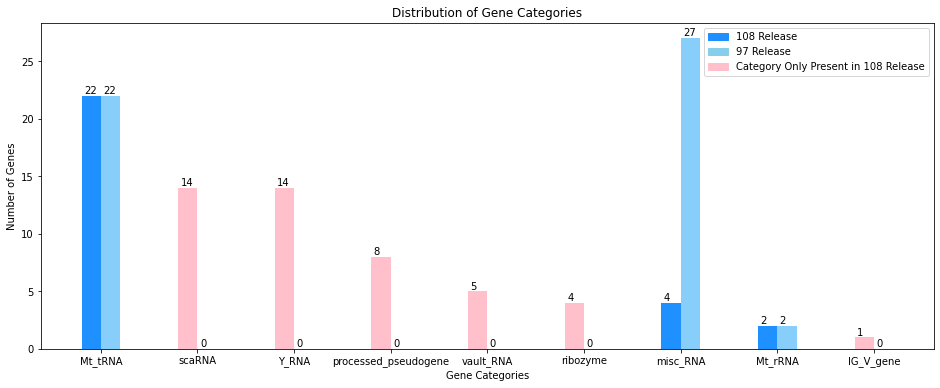

In [218]:
# Plot the gene categories against the number of times they occur in genes, for both assemblies - Part 2

ng = new.genes

categories2 = ng["gene_biotype"].value_counts().index.tolist()[7:]
new_category_counts2 = ng["gene_biotype"].value_counts()[7:]
old_category_counts2 = [22, 0, 0, 0, 0, 0, 27, 2, 0]

# Make a numpy array for the positional information of each "bar pair"
x_axis = np.arange(len(categories2))

fig = plt.figure(figsize=(16, 6))
plt.title("Distribution of Gene Categories")
plt.xlabel("Gene Categories")
plt.ylabel("Number of Genes")
plt.xticks(x_axis, categories2)
# Plot the new release gene category distribution
bars1 = plt.bar(x_axis-0.1, new_category_counts2, 0.2, label="108 Release", color=["dodgerblue", "pink", "pink",
                                                                           "pink", "pink", "pink", "dodgerblue", "dodgerblue", "pink"])
# Plot the old release gene category distribution
bars2 = plt.bar(x_axis+0.1, old_category_counts2, 0.2, label="97 Release", color="lightskyblue")

# Add exact numbers to each bar
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + .025, yval + .2, yval)
for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + .025, yval + .2, yval)

# Add the legend
new_patch = mpatches.Patch(color='dodgerblue', label='108 Release')
old_patch = mpatches.Patch(color='skyblue', label='97 Release')
only_new_patch = mpatches.Patch(color='pink', label='Category Only Present in 108 Release')
plt.legend(handles=[new_patch, old_patch, only_new_patch])

print()

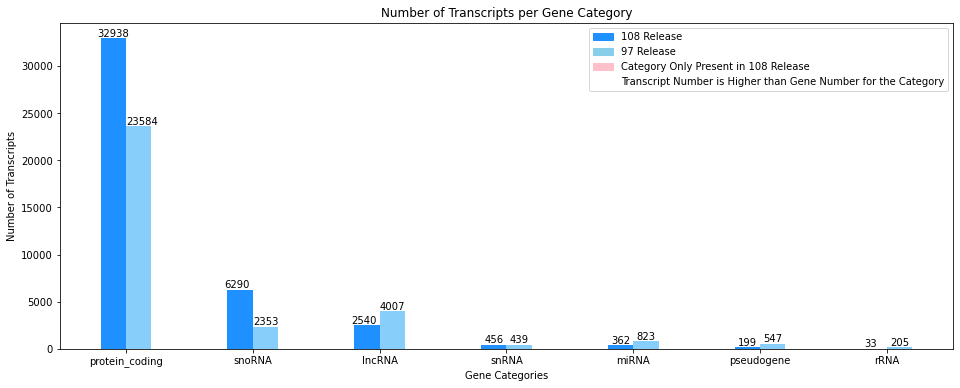

In [219]:
# Plot the gene categories against the number of times they occur in transcripts, for both assemblies - Part 2

ng = new.genes
nt = new.transcripts

categories1 = ng["gene_biotype"].value_counts().index.tolist()[:7]
new_category_counts1 = nt["transcript_biotype"].value_counts()[:7]
old_category_counts1 = [23584, 2353, 4007, 439, 823, 547, 205]


# Make a numpy array for the positional information of each "bar pair"
x_axis = np.arange(len(categories1))

fig = plt.figure(figsize=(16, 6))
plt.title("Number of Transcripts per Gene Category")
plt.xlabel("Gene Categories")
plt.ylabel("Number of Transcripts")
plt.xticks(x_axis, categories1)
# Plot the new release gene category distribution
bars1 = plt.bar(x_axis-0.1, new_category_counts1, 0.2, label="108 Release", color="dodgerblue")
# Plot the old release gene category distribution
bars2 = plt.bar(x_axis+0.1, old_category_counts1, 0.2, label="97 Release", color="lightskyblue")

# Add exact numbers to each bar
for i, bar in enumerate(bars1):
    yval = bar.get_height()
    if i < 3:
        plt.text(bar.get_x() - .025, yval + 200, yval)
    else:
        plt.text(bar.get_x() + .025, yval + 200, yval)
for i, bar in enumerate(bars2):
    yval = bar.get_height()
    if i < 3:
        plt.text(bar.get_x(), yval + 200, yval)
    else:
        plt.text(bar.get_x() + .025, yval + 200, yval)

# Add the legend
new_patch = mpatches.Patch(color='dodgerblue', label='108 Release')
old_patch = mpatches.Patch(color='skyblue', label='97 Release')
only_new_patch = mpatches.Patch(color='pink', label='Category Only Present in 108 Release')
astrisk_patch = mpatches.Patch(color="white", label='Transcript Number is Higher than Gene Number for the Category')
plt.legend(handles=[new_patch, old_patch, only_new_patch, astrisk_patch])

print()

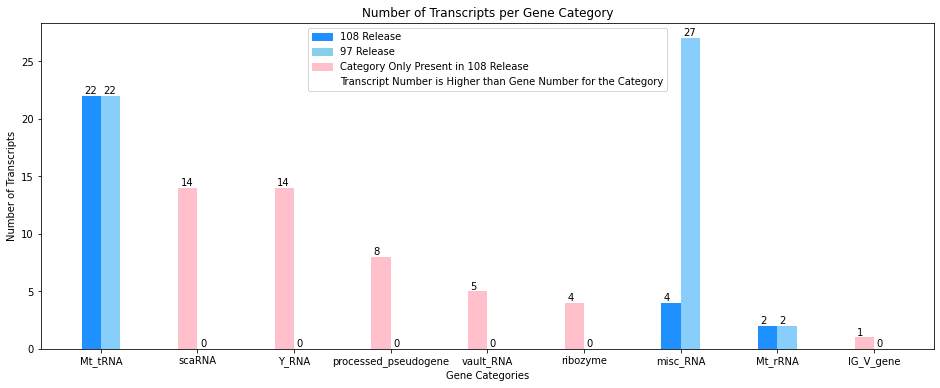

In [220]:
# Plot the gene categories against the number of times they occur in transcripts, for both assemblies - Part 2

ng = new.genes
nt = new.transcripts

categories2 = ng["gene_biotype"].value_counts().index.tolist()[7:]
new_category_counts2 = nt["transcript_biotype"].value_counts()[7:]
old_category_counts2 = [22, 0, 0, 0, 0, 0, 27, 2, 0]

# Make a numpy array for the positional information of each "bar pair"
x_axis = np.arange(len(categories2))

fig = plt.figure(figsize=(16, 6))
plt.title("Number of Transcripts per Gene Category")
plt.xlabel("Gene Categories")
plt.ylabel("Number of Transcripts")
plt.xticks(x_axis, categories2)
# Plot the new release gene category distribution
bars1 = plt.bar(x_axis-0.1, new_category_counts2, 0.2, label="108 Release", color=["dodgerblue", "pink", "pink",
                                                                           "pink", "pink", "pink", "dodgerblue", "dodgerblue", "pink"])
# Plot the old release gene category distribution
bars2 = plt.bar(x_axis+0.1, old_category_counts2, 0.2, label="97 Release", color="lightskyblue")

# Add exact numbers to each bar
for i, bar in enumerate(bars1):
    yval = bar.get_height()
    plt.text(bar.get_x() + .025, yval + .2, yval)
for i, bar in enumerate(bars2):
    yval = bar.get_height()
    plt.text(bar.get_x() + .025, yval + .2, yval)

# Add the legend
new_patch = mpatches.Patch(color='dodgerblue', label='108 Release')
old_patch = mpatches.Patch(color='skyblue', label='97 Release')
only_new_patch = mpatches.Patch(color='pink', label='Category Only Present in 108 Release')
astrisk_patch = mpatches.Patch(color="white", label='Transcript Number is Higher than Gene Number for the Category')
plt.legend(handles=[new_patch, old_patch, only_new_patch, astrisk_patch], loc="upper center")

print()

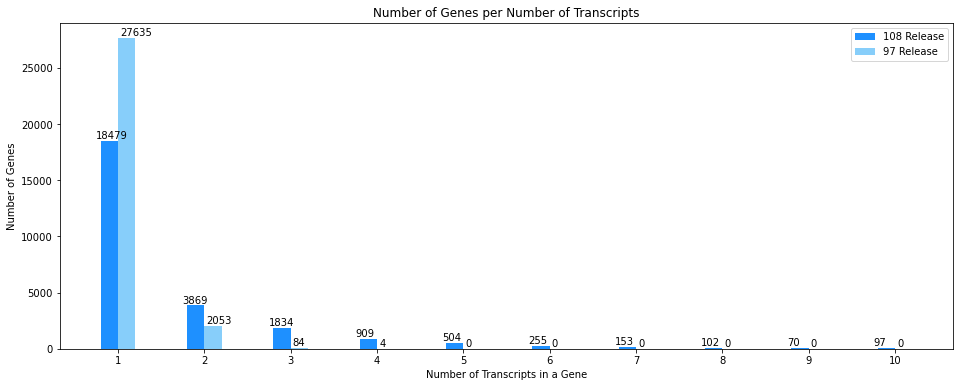

In [221]:
# Plot the number of transcripts for each category of transcript number for New Assembly and Old Assembly

nt = new.transcripts
ot = old.transcripts

trans_counts = [i+1 for i in range(10)]
trans_freq_new = list(nt["gene_id"].value_counts().value_counts())
trans_freq_new[8], trans_freq_new[9] = trans_freq_new[9], trans_freq_new[8]
trans_freq_old = list(ot["gene_id"].value_counts().value_counts()) + [0, 0, 0, 0, 0, 0]

# Make a numpy array for the positional information of each "bar pair"
x_axis = np.arange(len(trans_counts))

fig = plt.figure(figsize=(16, 6))
plt.title("Number of Genes per Number of Transcripts")
plt.xlabel("Number of Transcripts in a Gene")
plt.ylabel("Number of Genes")
plt.xticks(x_axis, trans_counts)
# Plot the new release distribution
bars1 = plt.bar(x_axis-0.1, trans_freq_new, 0.2, label="108 Release", color="dodgerblue")
# Plot the old release gene category distribution
bars2 = plt.bar(x_axis+0.1, trans_freq_old, 0.2, label="97 Release", color="lightskyblue")

# Add exact numbers to each bar
for i, bar in enumerate(bars1):
    yval = bar.get_height()
    plt.text(bar.get_x() - .05, yval + 200, yval)
for i, bar in enumerate(bars2):
    yval = bar.get_height()
    plt.text(bar.get_x() + .025, yval + 200, yval)

# Add the legend
plt.legend()

print()